# Implementation of Variational AutoEncoder (VAE)

     VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    
     Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
     
     Author-email:  mskang@handong.edu

     python and pytorch version: python=3.7, pytorch=1.3.1

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [2]:
# Model Hyperparameters

dataset_path = '/root/data/cifar10/'

cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")


batch_size = 128

x_dim  = 3*32*32
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

###    Step 1. Load (or download) Dataset

In [18]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root=dataset_path, train=True,
                                        download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, drop_last = True)

test_dataset = torchvision.datasets.CIFAR10(root=dataset_path, train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


### Step 2. Define our model: Variational AutoEncoder (VAE)

In [19]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [20]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [21]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [22]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [23]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [32]:
# for i in range(50000):
#     if train_dataset[i][0].size() == train_dataset[0][0].size(): pass
#     else: print(i)
# #     if i == 10: break
# #     print()
# # train_dataset[0][0].size()

In [24]:
# from tqdm import tqdm
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(tqdm(train_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...


100%|██████████| 390/390 [00:04<00:00, 82.41it/s]


	Epoch 1 complete! 	Average Loss:  -35455.51264996761


100%|██████████| 390/390 [00:04<00:00, 82.39it/s]


	Epoch 2 complete! 	Average Loss:  -39573.47688885765


100%|██████████| 390/390 [00:04<00:00, 83.04it/s]


	Epoch 3 complete! 	Average Loss:  -39745.23709129981


100%|██████████| 390/390 [00:04<00:00, 83.45it/s]


	Epoch 4 complete! 	Average Loss:  -40875.141378133034


100%|██████████| 390/390 [00:04<00:00, 81.14it/s]


	Epoch 5 complete! 	Average Loss:  -42239.37962925771


100%|██████████| 390/390 [00:04<00:00, 82.55it/s]


	Epoch 6 complete! 	Average Loss:  -43133.78731523136


100%|██████████| 390/390 [00:04<00:00, 84.49it/s]


	Epoch 7 complete! 	Average Loss:  -44050.621344794345


100%|██████████| 390/390 [00:04<00:00, 82.76it/s]


	Epoch 8 complete! 	Average Loss:  -44745.94804386247


100%|██████████| 390/390 [00:04<00:00, 83.64it/s]


	Epoch 9 complete! 	Average Loss:  -45215.9942561054


100%|██████████| 390/390 [00:04<00:00, 82.31it/s]


	Epoch 10 complete! 	Average Loss:  -45800.728279643314


100%|██████████| 390/390 [00:04<00:00, 79.43it/s]


	Epoch 11 complete! 	Average Loss:  -46206.97423280848


100%|██████████| 390/390 [00:04<00:00, 82.41it/s]


	Epoch 12 complete! 	Average Loss:  -46707.05303060733


100%|██████████| 390/390 [00:04<00:00, 82.08it/s]


	Epoch 13 complete! 	Average Loss:  -47083.03438303342


100%|██████████| 390/390 [00:04<00:00, 83.81it/s]


	Epoch 14 complete! 	Average Loss:  -47447.332141709514


100%|██████████| 390/390 [00:04<00:00, 84.26it/s]


	Epoch 15 complete! 	Average Loss:  -47785.24173562018


100%|██████████| 390/390 [00:04<00:00, 82.97it/s]


	Epoch 16 complete! 	Average Loss:  -48132.315673200515


100%|██████████| 390/390 [00:04<00:00, 82.06it/s]


	Epoch 17 complete! 	Average Loss:  -48417.13905848329


100%|██████████| 390/390 [00:04<00:00, 84.18it/s]


	Epoch 18 complete! 	Average Loss:  -48612.25053221401


100%|██████████| 390/390 [00:04<00:00, 82.07it/s]


	Epoch 19 complete! 	Average Loss:  -48913.36489797558


100%|██████████| 390/390 [00:04<00:00, 81.86it/s]


	Epoch 20 complete! 	Average Loss:  -49163.215898136245


100%|██████████| 390/390 [00:04<00:00, 82.26it/s]


	Epoch 21 complete! 	Average Loss:  -49412.444579450515


100%|██████████| 390/390 [00:04<00:00, 82.51it/s]


	Epoch 22 complete! 	Average Loss:  -49600.87209792738


100%|██████████| 390/390 [00:04<00:00, 83.89it/s]


	Epoch 23 complete! 	Average Loss:  -49780.562349373395


100%|██████████| 390/390 [00:04<00:00, 83.61it/s]


	Epoch 24 complete! 	Average Loss:  -49944.34139018316


100%|██████████| 390/390 [00:04<00:00, 83.01it/s]


	Epoch 25 complete! 	Average Loss:  -50096.931324309124


100%|██████████| 390/390 [00:04<00:00, 82.30it/s]


	Epoch 26 complete! 	Average Loss:  -50295.69177779563


100%|██████████| 390/390 [00:04<00:00, 82.45it/s]


	Epoch 27 complete! 	Average Loss:  -50454.354554948586


100%|██████████| 390/390 [00:04<00:00, 82.99it/s]


	Epoch 28 complete! 	Average Loss:  -50628.77184085797


100%|██████████| 390/390 [00:04<00:00, 81.71it/s]


	Epoch 29 complete! 	Average Loss:  -50773.28485499679


100%|██████████| 390/390 [00:04<00:00, 82.64it/s]

	Epoch 30 complete! 	Average Loss:  -50890.517081057194
Finish!!


### Step 5. Generate images from test dataset

In [25]:
import matplotlib.pyplot as plt

In [26]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/79 [00:00<?, ?it/s]


In [36]:
def show_image(x, idx):
    x = x.view(batch_size, 3, 32, 32)

    fig = plt.figure()
    plt.imshow(convert_to_img(x[idx]))
#     plt.imshow(x[idx].cpu().numpy())

In [35]:
from ig_pkg.misc import convert_to_img
# show_image(x, idx=0)
temp = x[0]


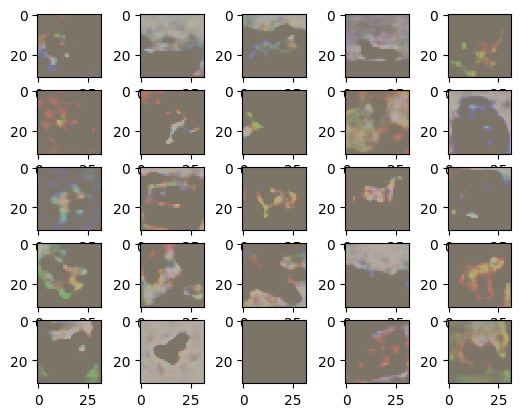

In [41]:
fig, axes = plt.subplots(5, 5)
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))
temp = x_hat.view(128, 3, 32, 32)
for i in range(25):
    ax = next(axes_flat)
    ax.imshow(convert_to_img(temp[i]))


### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [15]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [16]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

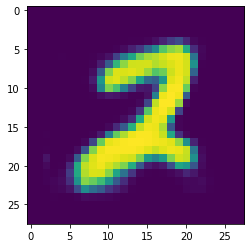

In [17]:
show_image(generated_images, idx=12)

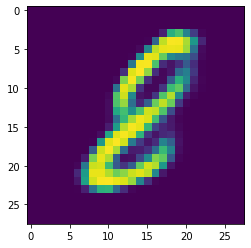

In [18]:
show_image(generated_images, idx=0)

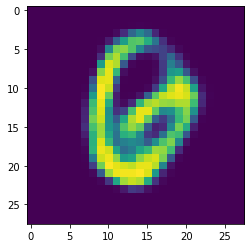

In [19]:
show_image(generated_images, idx=1)

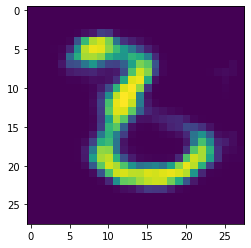

In [20]:
show_image(generated_images, idx=10)

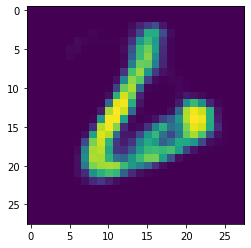

In [21]:
show_image(generated_images, idx=20)

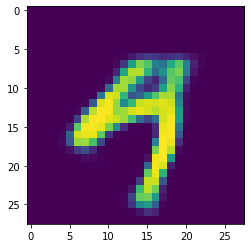

In [22]:
show_image(generated_images, idx=50)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

# from models import BaseVAE
# from .types_ import *

# from .types_ import *
from torch import nn
from abc import abstractmethod

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass


Tensor = TypeVar('torch.tensor')

class VanillaVAE(BaseVAE):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]
